# 用 Transformer 模型进行预测

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, Dropout
from tensorflow.keras.layers import Attention
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random



In [3]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [52]:
def load_and_split_data(filepath, sequence_length, predict_length, scaler_X=None, scaler_y=None):
    data = pd.read_csv(filepath)
    # 特征和标签的定义
    features = ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
    label = 'cnt'
    data['dteday'] = pd.to_datetime(data['dteday'])
    data['dteday'] = data['dteday'].dt.day 
    X = data[features]
    y = data[label]
    
    if scaler_X is None:
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler_X.fit_transform(X)
    else:
        X_scaled = scaler_X.transform(X)
    
    if scaler_y is None:
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    else:
        y_scaled = scaler_y.transform(y.values.reshape(-1, 1))
    
    X_processed, y_processed = [], []
    for i in range(len(X_scaled) - sequence_length - predict_length + 1):
        X_processed.append(X_scaled[i:i + sequence_length])
        y_processed.append(y_scaled[i + sequence_length:i + sequence_length + predict_length])
    
    X_processed, y_processed = np.array(X_processed), np.array(y_processed)
    
    return X_processed, y_processed, scaler_X, scaler_y

In [53]:
train_file_path = 'train_data.csv'
test_file_path = 'test_data.csv'
sequence_length=96
short_predict_length=96
long_predict_length=240

In [54]:
# 短期预测
X_train_short, y_train_short, scaler_X_short, scaler_y_short= load_and_split_data(train_file_path,sequence_length,short_predict_length)
X_test_short, y_test_short,_,_ = load_and_split_data(test_file_path,sequence_length,short_predict_length,scaler_X_short,scaler_y_short)
# 长期预测
X_train_long, y_train_long, scaler_X_long, scaler_y_long = load_and_split_data(train_file_path,sequence_length,long_predict_length)
X_test_long, y_test_long,_,_ = load_and_split_data(test_file_path,sequence_length,long_predict_length,scaler_X_long,scaler_y_long)
print(X_train_short.shape,y_train_short.shape)
print(X_test_short.shape,y_test_short.shape)
print(X_train_long.shape,y_train_long.shape)
print(X_test_long.shape,y_test_long.shape)
#print(X_train[0,0],y_train[0,0])

(15025, 96, 16) (15025, 96, 1)
(1969, 96, 16) (1969, 96, 1)
(14881, 96, 16) (14881, 240, 1)
(1825, 96, 16) (1825, 240, 1)


In [55]:
print(y_test_short.shape)
print(y_test_short)

(1969, 96, 1)
[[[0.80327869]
  [0.39241803]
  [0.26536885]
  ...
  [0.01844262]
  [0.1454918 ]
  [0.36987705]]

 [[0.39241803]
  [0.26536885]
  [0.31045082]
  ...
  [0.1454918 ]
  [0.36987705]
  [0.7295082 ]]

 [[0.26536885]
  [0.31045082]
  [0.47848361]
  ...
  [0.36987705]
  [0.7295082 ]
  [0.39036885]]

 ...

 [[0.04405738]
  [0.02561475]
  [0.02459016]
  ...
  [0.12090164]
  [0.09016393]
  [0.09118852]]

 [[0.02561475]
  [0.02459016]
  [0.00819672]
  ...
  [0.09016393]
  [0.09118852]
  [0.06147541]]

 [[0.02459016]
  [0.00819672]
  [0.00409836]
  ...
  [0.09118852]
  [0.06147541]
  [0.04918033]]]


In [7]:
# 定义Transformer模型
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):
    def __init__(self, sequence_length, feature_dim, embed_dim, num_heads, ff_dim, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embed_layer = Dense(embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.global_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.output_layer = Dense(output_dim)

    def call(self, inputs, training=False):
        x = self.embed_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        x = self.global_pool(x)
        return self.output_layer(x)

In [8]:
def train_and_evaluate(model, train_data, test_data, num_epochs, batch_size):
    X_train, y_train = train_data
    X_test, y_test = test_data
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    # 训练模型
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=num_epochs, batch_size=batch_size,verbose=1)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
    return mse, mae

In [11]:
# 超参数定义
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 2
num_epochs = 10
batch_size = 32
num_trials = 10

# 短期预测

In [12]:
output_dim = short_predict_length
mse_results = []
mae_results = []
transformer_model_short = TransformerModel(sequence_length, X_train_short.shape[2], embed_dim, num_heads, ff_dim, num_layers, output_dim)
for i in range(num_trials):
    print(f"Trial {i}")
    mse, mae = train_and_evaluate(transformer_model_short, (X_train_short, y_train_short), (X_test_short, y_test_short), num_epochs, batch_size)
    mse_results.append(mse)
    mae_results.append(mae)

# 输出平均值和标准差
print(f"Average MSE: {np.mean(mse_results):.4f} ±  {np.std(mse_results):.4f}")
print(f"Average MAE: {np.mean(mae_results):.4f} ± {np.std(mae_results):.4f}")

Trial 0
Epoch 1/10
376/376 [==============================] - 33s 75ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1295 - val_loss: 0.0570 - val_mean_squared_error: 0.0570 - val_mean_absolute_error: 0.1892
Epoch 2/10
376/376 [==============================] - 30s 79ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1168 - val_loss: 0.0557 - val_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.1904
Epoch 3/10
376/376 [==============================] - 31s 82ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1161 - val_loss: 0.0559 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.1894
Epoch 4/10
376/376 [==============================] - 29s 77ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1154 - val_loss: 0.0560 - val_mean_squared_error: 0.0560 - val_mean_absolute_error: 0.1895
Epoch 5/10
376/376 [==============================] - 29s 77ms/step - loss: 0.02

376/376 [==============================] - 28s 76ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0468 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1180
Epoch 7/10
376/376 [==============================] - 29s 76ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0463 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1087
Epoch 8/10
376/376 [==============================] - 29s 76ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0461 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1087
Epoch 9/10
376/376 [==============================] - 29s 76ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0459 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1045
Epoch 10/10
62/62 [==============================] - 2s 24ms/step
Trial 4
Epoch 1/10
376/376 [=====

62/62 [==============================] - 2s 22ms/step
Trial 7
Epoch 1/10
376/376 [==============================] - 33s 76ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0398 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1111
Epoch 2/10
376/376 [==============================] - 28s 76ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0397 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1113
Epoch 3/10
376/376 [==============================] - 28s 76ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0396 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1036
Epoch 4/10
376/376 [==============================] - 28s 76ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0397 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1083
Epoch 5/10
376/376 [======

In [16]:
# 模型预测
y_pred_short_transformer = transformer_model_short.predict(X_test_short)

# 反归一化预测值与真实值
y_pred_short_transformer  = scaler_y_short.inverse_transform(y_pred_short_transformer.reshape(-1, 1))


62/62 [==============================] - 1s 23ms/step


In [48]:
y_test_short_transformer  = scaler_y_short.inverse_transform(y_test_short.reshape(-1, 1))

In [50]:
print(y_test_short, y_test_short_transformer)

[[[0.80327869]
  [0.39241803]
  [0.26536885]
  ...
  [0.01844262]
  [0.1454918 ]
  [0.36987705]]

 [[0.39241803]
  [0.26536885]
  [0.31045082]
  ...
  [0.1454918 ]
  [0.36987705]
  [0.7295082 ]]

 [[0.26536885]
  [0.31045082]
  [0.47848361]
  ...
  [0.36987705]
  [0.7295082 ]
  [0.39036885]]

 ...

 [[0.04405738]
  [0.02561475]
  [0.02459016]
  ...
  [0.12090164]
  [0.09016393]
  [0.09118852]]

 [[0.02561475]
  [0.02459016]
  [0.00819672]
  ...
  [0.09016393]
  [0.09118852]
  [0.06147541]]

 [[0.02459016]
  [0.00819672]
  [0.00409836]
  ...
  [0.09118852]
  [0.06147541]
  [0.04918033]]] [[0.79175625]
 [0.38678909]
 [0.26156233]
 ...
 [0.08988049]
 [0.06059359]
 [0.04847487]]


In [56]:
y_test_short_transformer  = scaler_y_short.inverse_transform(y_test_short.reshape(-1, 1))

In [57]:
print(y_pred_short_transformer .flatten())
print(y_test_short_transformer .flatten())

[428.7045   304.8525   220.51021  ...  55.860054  41.79549   -2.17161 ]
[785. 384. 260. ...  90.  61.  49.]


In [58]:
# 可视化预测结果
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true[:300], label='Ground Truth',color='blue')
    plt.plot(y_pred[:300], label='Predictions',color='red')
    plt.xlabel('instant')
    plt.ylabel('cnt')
    plt.title(title)
    plt.legend()
    plt.show()


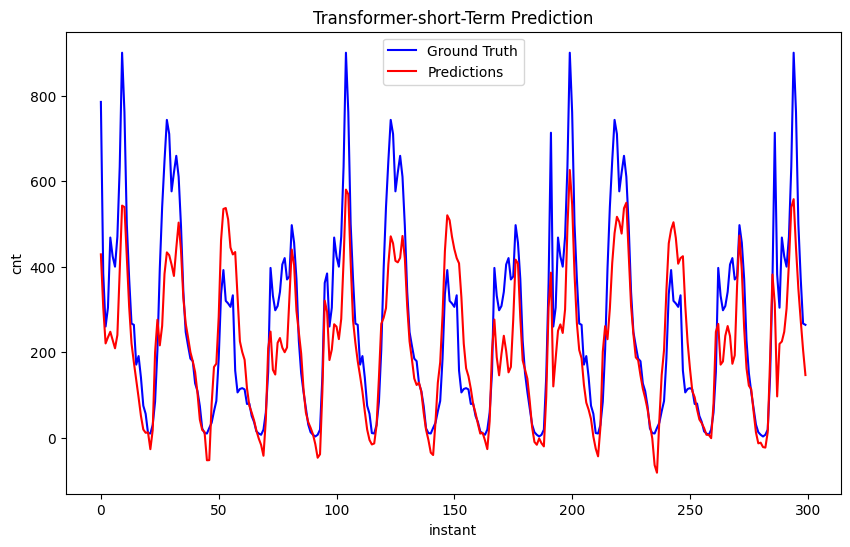

In [59]:
plot_predictions(y_test_short_transformer .flatten(), y_pred_short_transformer .flatten(), 'Transformer-short-Term Prediction')

In [60]:
# 长期预测
output_dim = long_predict_length
mse_results = []
mae_results = []
transformer_model_long= TransformerModel(sequence_length, X_train_long.shape[2], embed_dim, num_heads, ff_dim, num_layers, output_dim)
for i in range(num_trials):
    print(f"Trial {i}")
    mse, mae = train_and_evaluate(transformer_model_long, (X_train_long, y_train_long), (X_test_long, y_test_long), num_epochs, batch_size)
    mse_results.append(mse)
    mae_results.append(mae)

# 输出平均值和标准差
print(f"Average MSE: {np.mean(mse_results):.4f} ±  {np.std(mse_results):.4f}")
print(f"Average MAE: {np.mean(mae_results):.4f} ± {np.std(mae_results):.4f}")

Trial 0
Epoch 1/10
372/372 [==============================] - 31s 71ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - mean_absolute_error: 0.1258 - val_loss: 0.0549 - val_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.1898
Epoch 2/10
372/372 [==============================] - 27s 71ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1161 - val_loss: 0.0554 - val_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.1878
Epoch 3/10
372/372 [==============================] - 28s 74ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1155 - val_loss: 0.0568 - val_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.1882
Epoch 4/10
372/372 [==============================] - 27s 74ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1150 - val_loss: 0.0576 - val_mean_squared_error: 0.0576 - val_mean_absolute_error: 0.1884
Epoch 5/10
372/372 [==============================] - 27s 74ms/step - loss: 0.02

372/372 [==============================] - 27s 74ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0531 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1294
Epoch 7/10
372/372 [==============================] - 27s 74ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0530 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1239
Epoch 8/10
372/372 [==============================] - 27s 74ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0526 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1293
Epoch 9/10
372/372 [==============================] - 29s 77ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0530 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1078
Epoch 10/10
58/58 [==============================] - 2s 23ms/step
Trial 4
Epoch 1/10
372/372 [=====

58/58 [==============================] - 2s 23ms/step
Trial 7
Epoch 1/10
372/372 [==============================] - 32s 75ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0469 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1164
Epoch 2/10
372/372 [==============================] - 28s 75ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0470 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1108
Epoch 3/10
372/372 [==============================] - 28s 75ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0463 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1039
Epoch 4/10
372/372 [==============================] - 856s 2s/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0467 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1021
Epoch 5/10
372/372 [=======

In [62]:
# 模型预测
y_pred_long_transformer = transformer_model_long.predict(X_test_short)
y_pred_long_transformer  = scaler_y_long.inverse_transform(y_pred_long_transformer.reshape(-1, 1))
y_test_long_transformer  = scaler_y_long.inverse_transform(y_test_long.reshape(-1, 1))

62/62 [==============================] - 3s 48ms/step


In [63]:
print(y_pred_long_transformer .flatten())
print(y_test_short_transformer .flatten())

[381.3704   357.78128  364.81635  ...  67.43598   40.906727  36.7717  ]
[785. 384. 260. ...  90.  61.  49.]


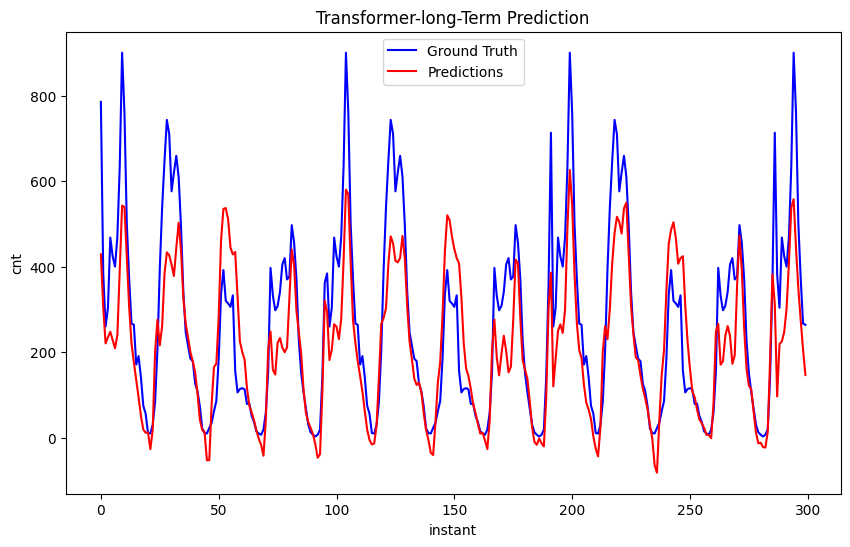

In [64]:
plot_predictions(y_test_short_transformer .flatten(), y_pred_short_transformer .flatten(), 'Transformer-long-Term Prediction')